# Exemplar-Based Image Inpainting

Ce notebook implémente une méthode d'inpainting d'image basée sur l'algorithme de Criminisi et al.

## Sections du Notebook

In [55]:

from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.color import rgb2gray


import numpy as np
from scipy.ndimage import convolve
# Charger les images directement depuis un fichier
def load_image_and_mask(image_path, mask_path):
    image = imread(image_path)
    mask = imread(mask_path, as_gray=True)
    mask = (mask > 0.5).astype(np.uint8)  # Assurer que le masque est binaire
    return image, mask


1. Initialisation des Données
2. Calcul des Gradients et Normales
3. Détection et Mise à Jour du Front
4. Remplissage de la Région Cible
5. Mise à Jour de l'Image
6. Exécution de l'Algorithme Principal

## 1. Initialisation des Données

Dans cette section, nous initialisons les données nécessaires, incluant l'image de travail, le masque, la confiance, et les données de gradient.

In [100]:

def initialize_data(image, mask, patch_size):
    working_image = np.copy(image).astype('uint8')
    working_mask = mask.round().astype('uint8')
    
    # Remplir les zones masquées avec du blanc pour les visualiser
    working_image[working_mask == 1] = [255, 255, 255]
    
    confidence = (1 - working_mask).astype(float)
    data = np.ones_like(confidence)  # Initialiser `data` pour tous les pixels
    
    return working_image, working_mask, confidence, data




## 2. Calcul des Gradients et Normales

Cette section couvre le calcul des vecteurs normaux et des gradients, qui sont cruciaux pour déterminer la direction et la force des structures à l'intérieur de l'image.

In [57]:
def calc_normal_matrix(mask):
    x_kernel = np.array([[.25, 0, -.25], [.5, 0, -.5], [.25, 0, -.25]])
    y_kernel = np.array([[-.25, -.5, -.25], [0, 0, 0], [.25, .5, .25]])
    x_normal = convolve(mask.astype(float), x_kernel)
    y_normal = convolve(mask.astype(float), y_kernel)
    normal = np.dstack((x_normal, y_normal))
    norm = np.sqrt(x_normal**2 + y_normal**2).reshape(mask.shape[0], mask.shape[1], 1).repeat(2, axis=2)
    return normal / np.where(norm == 0, 1, norm)

def calc_gradient_matrix(image, mask):
    grey_image = rgb2gray(image)
    grey_image[mask == 1] = None
    gradient = np.nan_to_num(np.array(np.gradient(grey_image)))
    gradient_val = np.sqrt(gradient[0]**2 + gradient[1]**2)
    return gradient, gradient_val


## Fonctions Utilitaires pour Manipuler les Patchs

In [58]:

def get_patch(point, patch_size, shape):
    half_size = patch_size // 2
    return [[max(0, point[0] - half_size), min(point[0] + half_size, shape[0] - 1)],
            [max(0, point[1] - half_size), min(point[1] + half_size, shape[1] - 1)]]

def get_patch_data(source, patch):
    return source[patch[0][0]:patch[0][1]+1, patch[1][0]:patch[1][1]+1]

def copy_to_patch(destination, patch, data):
    destination[patch[0][0]:patch[0][1]+1, patch[1][0]:patch[1][1]+1] = data

def calc_patch_difference(image, target_patch, source_patch, mask):
    mask_data = 1 - get_patch_data(mask, target_patch)
    rgb_mask = mask_data[:, :, np.newaxis].repeat(3, axis=2)
    target_data = get_patch_data(image, target_patch) * rgb_mask
    source_data = get_patch_data(image, source_patch) * rgb_mask
    return np.sum((target_data - source_data) ** 2)


On utilise un filtre laplacien pour détecter les bords du masque, et on met à jour les priorités en fonction des valeurs de confiance et de gradient.

In [92]:

from skimage.filters import laplace

def find_front(mask):
    return (laplace(mask) > 0).astype('uint8')

def update_priority(front, confidence, data, working_mask):
    # Priorité initiale basée sur la confiance et les données
    priority = confidence * data * front

    # Cibler uniquement les zones masquées avec une priorité
    priority[working_mask == 0] = 0  # Seules les zones masquées reçoivent une priorité
    return priority



def update_confidence(confidence, front, patch_size):
    for point in np.argwhere(front == 1):
        patch = get_patch(point, patch_size, confidence.shape)
        confidence[point[0], point[1]] = np.mean(get_patch_data(confidence, patch))
    return confidence


## 4. Remplissage de la Région Cible

On sélectionne le patch source le plus similaire pour chaque pixel cible à l'intérieur de la région du masque à remplir.

In [124]:

from skimage.color import rgb2lab

def find_best_patch(target_pixel, patch_size, image, mask, search_window=50):
    target_patch = get_patch(target_pixel, patch_size, image.shape[:2])
    best_patch, best_difference = None, float('inf')
    lab_image = rgb2lab(image)
    
    # Limiter la recherche autour du pixel cible
    min_y = max(0, target_pixel[0] - search_window)
    max_y = min(image.shape[0], target_pixel[0] + search_window)
    min_x = max(0, target_pixel[1] - search_window)
    max_x = min(image.shape[1], target_pixel[1] + search_window)
    
    for y in range(min_y, max_y - patch_size + 1):
        for x in range(min_x, max_x - patch_size + 1):
            source_patch = [[y, y + patch_size - 1], [x, x + patch_size - 1]]
            if np.sum(get_patch_data(mask, source_patch)) != 0:
                continue
            # Vérifie que les dimensions correspondent
            target_data = get_patch_data(image, target_patch)
            source_data = get_patch_data(image, source_patch)
            if target_data.shape == source_data.shape:  # Assure que les dimensions correspondent
                difference = calc_patch_difference(lab_image, target_patch, source_patch, mask)
                if difference < best_difference:
                    best_patch, best_difference = source_patch, difference
    return best_patch or target_patch






## 5. Mise à Jour de l'Image

In [125]:
def update_image(working_image, working_mask, target_pixel, source_patch, patch_size):
    target_patch = get_patch(target_pixel, patch_size, working_image.shape[:2])
    mask = get_patch_data(working_mask, target_patch)
    
    rgb_mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    source_data = get_patch_data(working_image, source_patch)
    target_data = get_patch_data(working_image, target_patch)

    # Assurer que l'on ne copie que dans les zones masquées
    if np.any(mask == 1):  # Vérifier s'il y a des pixels masqués
        new_data = source_data * rgb_mask + target_data * (1 - rgb_mask)
        copy_to_patch(working_image, target_patch, new_data)
        copy_to_patch(working_mask, target_patch, 0)





## 6. Exécution de l'Algorithme Principal

Cette fonction `main` orchestre toutes les étapes de l'algorithme d'inpainting en appelant les fonctions précédentes dans l'ordre approprié.

In [128]:
def main(image, mask, patch_size=15):  # Utiliser un plus grand patch pour accélérer
    working_image, working_mask, confidence, data = initialize_data(image, mask, patch_size)
    total_pixels = np.sum(mask == 1)
    
    plt.figure()
    while np.sum(working_mask) > 0:
        front = find_front(working_mask)
        priority = update_priority(front, confidence, data, working_mask)
        target_pixel = np.unravel_index(np.argmax(priority), priority.shape)
        
        source_patch = find_best_patch(target_pixel, patch_size, working_image, working_mask)
        update_image(working_image, working_mask, target_pixel, source_patch, patch_size)
        confidence = update_confidence(confidence, front, patch_size)
        
        remaining_pixels = np.sum(working_mask)
        filled_percentage = (1 - remaining_pixels / total_pixels) * 100
        
        print(f"Remplissage : {filled_percentage:.2f}%", end="\r")  # Affichage sur la même ligne
    # Affichage final une fois terminé
    plt.imshow(working_image)
    plt.title("Image Restaurée Complète")
    plt.axis('off')
    plt.show()
    return working_image


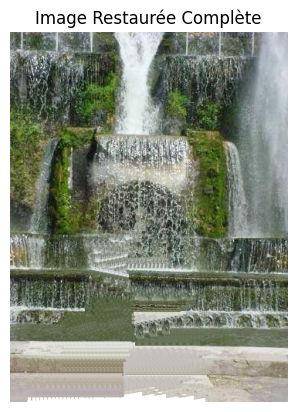

In [129]:
image_path = 'resources/image1.jpg'
mask_path = 'resources/mask1.jpg'
image, mask = load_image_and_mask(image_path, mask_path)

# Lancer l'algorithme avec affichage en temps réel
result = main(image, mask, patch_size=9)



